## Importing libraries

In [1]:
# libraries
from __future__ import print_function, division
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import BayesianLayers
from compression import compute_compression_rate, compute_reduced_weights
from utils import visualize_pixel_importance, generate_gif, visualise_weights

import os, sys
import itertools
from scipy import linalg
import matplotlib as mpl
!pip install pypsa
!pip install pandapower
import pypsa
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate
import random as rand
import pandas as pd
from sklearn import mixture
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
sns.set()
rand.seed(2020)
tf.random.set_seed(2020)
torch.manual_seed(2020)

In [2]:
from data_preprocessing import extract_consumption_values
from bic import bic_criterion_gmm
from define_network import define_network
from generate_samples import generate_samples
from compress_model import compress_model

## Defining parameters

In [17]:
net_case = "case_3" # Select ['case_14s', 'case_57', 'case_3']
N = 60000.  # number of data points in the training set
n_of_network_samples = 100
n_of_gaussians = 5
train_frac = 0.8
percent_of_measurements = 0.8
estimation_method = 'bad_data_removal' # Select ['standard','bad_data_removal']
layer_proportions = [20,10]
net_type = "pypsa_3"

In [4]:
os.makedirs("./plots/", exist_ok=True)

## Fitting Solar and Normal data separately with Gaussian Mixture
#### Initially, a GMM with 3 components will be fitted, like in the original paper. Later, other pdfs will be tested.

In [5]:
os.system("unzip electricity_data.zip")
base_path = "./electricity_data/"

train_data_path = base_path + "2011-2012 Solar home electricity data v2.csv"
test_data_path = base_path + "2012-2013 Solar home electricity data v2.csv"

In [6]:
train_data = pd.read_csv(train_data_path, skiprows=1)
test_data = pd.read_csv(test_data_path, skiprows=1)

### GC = General Consumption for electricity supplied all the time (primary tariff, either inclining block or time of use rates), excluding solar generation and controlled load supply 
### CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)
### GG = Gross Generation for electricity generated by the solar system with a gross metering configuration, measured separately to household loads

In [7]:
test_data.tail()

Customer  Generator Capacity  Postcode Consumption Category  \
268552       300                3.36      2086                   GC   
268553       300                3.36      2086                   GG   
268554       300                3.36      2086                   CL   
268555       300                3.36      2086                   GC   
268556       300                3.36      2086                   GG   

              date   0:30   1:00   1:30   2:00   2:30  ...  20:00  20:30  \
268552  29/06/2013  0.171  0.832  0.440  0.745  0.149  ...  0.383  0.404   
268553  29/06/2013  0.000  0.000  0.000  0.000  0.000  ...  0.000  0.000   
268554  30/06/2013  2.501  2.475  2.491  2.508  2.490  ...  0.000  0.000   
268555  30/06/2013  0.150  0.158  0.157  0.137  0.163  ...  0.625  0.595   
268556  30/06/2013  0.000  0.000  0.000  0.000  0.000  ...  0.000  0.000   

        21:00  21:30  22:00  22:30  23:00  23:30   0:00  Row Quality  
268552  0.367  0.398  0.350  0.228  0.170  0.139  0.171          NaN  
268553  0.000  0.000  0.000  0.000  0.000  0.000  0.000          NaN  
268554  0.000  0.000  0.000  0.000  0.000  0.000  2.468          NaN  
268555  0.695  0.646  0.581  0.458  0.472  0.732  0.297          NaN  
268556  0.000  0.000  0.000  0.000  0.000  0.000  0.000          NaN  

[5 rows x 54 columns]

In [8]:
train_data_general, train_data_solar = extract_consumption_values(train_data)
test_data_general, test_data_solar = extract_consumption_values(test_data)

In [9]:
train_values = np.reshape(train_data_general.values, (train_data_general.shape[0]*train_data_general.shape[1],1))
test_values = np.reshape(test_data_general.values, (test_data_general.shape[0]*test_data_general.shape[1],1))

In [ ]:
bic_criterion_gmm(10, train_values, test_values)

#### n_of_components=5 was initially chosen

In [10]:
gmm = mixture.GaussianMixture(n_components=n_of_gaussians)
#fit it to the data
gmm.fit(train_values)

GaussianMixture(n_components=5)

#### Solar consumption data was either 0 or NaN. We will only fit GMM on the General Consumption values.

## Generating samples from Network

In [11]:
net = define_network(net_case)

In [ ]:
# from pandapower.plotting.plotly import simple_plotly, vlevel_plotly
# from pandapower.plotting import cmap_discrete, create_line_collection, draw_collections
# sns.set_style("darkgrid")
# plt.figure()
#vlevel_plotly(net)
#simple_plotly(net)
# fig, ax = plt.subplots()
# pp.plotting.simple_plot(net, ax=ax)
# plt.savefig("net_14.pdf")
# plt.show()
# plt.close()
#plt.
# plt.legend()
# plt.show()
# pp.plotting.to_html(net, "test.html")
#, on_map=True)#, projection='epsg:31467')
# pc = pp.plotting.create_bus_collection(net)
# pp.plotting.draw_collections(pc)
#pp.plotting.simple_plot(net)#, on_map=True)
# net = pn.case57()#"generation") #mv_oberrhein("generation")

# cmap_list = [((0, 10), "green"), ((10, 30), "yellow"), ((30, 57), "red")]

# cmap, norm = cmap_discrete(cmap_list)

# lc = create_line_collection(net, cmap=cmap, norm=norm)

# draw_collections([lc])

In [ ]:
# np.min(net.line['r_ohm_per_km'].values)
#net.line.loc[net.line.r_ohm_per_km == 0,'r_ohm_per_km'] = 10.0
#pp.diagnostic?
# net.line['r_ohm_per_km'].values
# np.random.choice(net.line.index, size=net.bus.shape[0])
# success_chi2 = pp.estimation.chi2_analysis(net, init="flat")

In [12]:
injection_values, network_state_samples, measurement_vector = generate_samples(net_case,n_of_network_samples,net, percent_of_measurements, estimation_method, gmm, net_type)

meas_indexes: [2, 0]
range(0, 3)
[2, 1]


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026149 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.033547 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.030480 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036123 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025721 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.040713 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034388 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034598 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026856 seconds
INFO:pypsa.pf:Performing non-linear l

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025927 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025849 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026621 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025798 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026035 seconds
INFO:pypsa.pf:Performing non-linear l

## Fitting NN Model

In [13]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(layer_proportions[0]*measurement_vector.shape[1],input_dim=measurement_vector.shape[1]),
    tf.keras.layers.Dense(layer_proportions[1]*measurement_vector.shape[1], input_dim=layer_proportions[0]*measurement_vector.shape[1]),
    tf.keras.layers.Dense(network_state_samples.shape[1], input_dim=layer_proportions[1]*measurement_vector.shape[1]),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=tf.keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    injection_values[:int(measurement_vector.shape[0]*train_frac)], # input
    network_state_samples[:int(measurement_vector.shape[0]*train_frac)], # output
    batch_size=int(measurement_vector.shape[0]*train_frac),
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=50,
    validation_data=(injection_values[int(measurement_vector.shape[0]*train_frac):], network_state_samples[int(measurement_vector.shape[0]*train_frac):]),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.


Average test loss:  0.001814099219977033


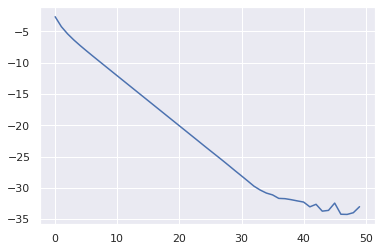

In [14]:
plt.plot(np.log(training_history.history['loss']))

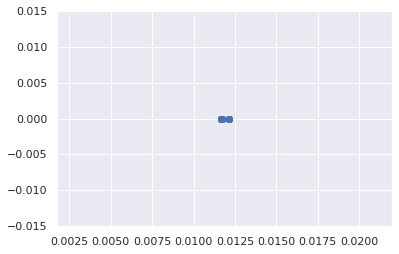

In [15]:
plt.scatter(model.predict(injection_values[-10:]),network_state_samples[-10:])

In [18]:
if __name__ == '__main__':

    class FLAGS:
        epochs=50
        batchsize=100
        thresholds=[-2.8, -3., -5.]
        
    FLAGS.cuda = torch.cuda.is_available()  # check if we can put the net on the GPU

    compress_model(injection_values, measurement_vector, train_frac, network_state_samples, layer_proportions, N, FLAGS)

torch.Size([80, 1, 2]) torch.Size([80, 3])
Epoch: 1 	Train loss: 0.10029446 	
Test loss: 0.00000885, Accuracy: 0/20 (0.00000000%)

Epoch: 2 	Train loss: 0.10147036 	
Test loss: 0.00003060, Accuracy: 0/20 (0.00000000%)

Epoch: 3 	Train loss: 0.09821232 	
Test loss: 0.00006398, Accuracy: 0/20 (0.00000000%)

Epoch: 4 	Train loss: 0.09739986 	
Test loss: 0.00010104, Accuracy: 0/20 (0.00000000%)

Epoch: 5 	Train loss: 0.09753814 	
Test loss: 0.00014139, Accuracy: 0/20 (0.00000000%)

Epoch: 6 	Train loss: 0.09663167 	
Test loss: 0.00018337, Accuracy: 0/20 (0.00000000%)

Epoch: 7 	Train loss: 0.09591722 	
Test loss: 0.00022809, Accuracy: 0/20 (0.00000000%)

Epoch: 8 	Train loss: 0.09538512 	
Test loss: 0.00027985, Accuracy: 0/20 (0.00000000%)

Epoch: 9 	Train loss: 0.09405265 	
Test loss: 0.00033329, Accuracy: 0/20 (0.00000000%)

Epoch: 10 	Train loss: 0.09276716 	
Test loss: 0.00038652, Accuracy: 0/20 (0.00000000%)

Epoch: 11 	Train loss: 0.09207420 	
Test loss: 0.00043873, Accuracy: 0/20 (0